In [1]:
!python --version

Python 3.7.3


#### Installing used libs

In [2]:
!pip install -U tensortrade==1.0.3 ta matplotlib tensorboardX scikit-learn

#### Checking if installed version of Tensortrade is the version 1.0.3

In [3]:
import tensortrade
print(tensortrade.__version__)

1.0.3


#### Importing used libs

In [4]:
import random

import ta
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import A2CAgent
import tensortrade.stochastic as sp 


#### Helper functions used to generate technical analysis features and create the environment for agent training and testing

In [5]:
def fetchTaFeatures(data):
    data = ta.add_all_ta_features(data, 'open', 'high', 'low', 'close', 'volume', fillna=True)
    data.columns = [name.lower() for name in data.columns]
    return data

def createEnv(config):

    with NameSpace("bitfinex"):
        bitfinex_streams = [
            Stream.source(list(config["data"][c]), dtype="float").rename(c) for c in config["data"].columns
        ]

    feed = DataFeed(bitfinex_streams)


    p = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")

    bitstamp = Exchange("bitfinex", service=execute_order)(
        p
    )
    
    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset
        
    ])
    
    env = default.create(
      feed=feed,
      portfolio=portfolio,
      action_scheme="managed-risk", # mudei aqui e parcialmente funcionou
      reward_scheme='risk-adjusted',
      window_size=config["window_size"]
    )
    
    return env


#### Creating data with stochastic process for training

<AxesSubplot:>

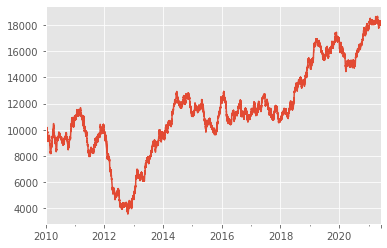

In [6]:
data = sp.fbm(
    base_price=10000,
    base_volume=5000,
    start_date="2010-01-01",
    times_to_generate=100000,
    time_frame='1H'
)

data.close.plot()


#### Adding technical analysis features to the dataframe

In [7]:
data = fetchTaFeatures(data)

/home/leandro/Documentos/ReinforcementLearningTrading/test/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/leandro/Documentos/ReinforcementLearningTrading/test/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


#### Normalizing the data

In [8]:
scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

#### Creating a training environment with a 10-period window

In [9]:
config = {
            "window_size": 10,
            "data": norm_data
        }

env = createEnv(config)

#### Running agent training with 100,000 steps and 10 episodes.
The agent will be saved in the "agents/" folder

In [10]:
!mkdir -p agents/

agent = A2CAgent(env)
reward = agent.train(n_steps=100000, save_path="agents/", n_episodes = 10)

====      AGENT ID: 80c23f59-f315-4cc4-a5c8-0475c9a6b77a      ====
====      EPISODE ID (1/10): f6b90bd0-9714-41ca-a006-bcf0dea215eb      ====


/home/leandro/Documentos/ReinforcementLearningTrading/test/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


====      EPISODE ID (2/10): 32c397d4-5c10-4acd-9b9c-82ab97567788      ====
====      EPISODE ID (3/10): 83a9d823-1fbb-4db1-a2c9-ff155a0de77e      ====
====      EPISODE ID (4/10): 2f613558-b0ed-4244-a60b-1a64b804a7ab      ====
====      EPISODE ID (5/10): 6d61d9a8-908f-4c35-9a90-1f925f7582e2      ====
====      EPISODE ID (6/10): e62b598f-0a58-427b-a0f9-a95247ab8d99      ====


#### Creating a new environment to check agent performance in training

In [11]:
env = createEnv({
    "window_size": 10, 
    "data": norm_data
})


#### Require action until step returns Done == True

In [12]:
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

In [13]:
reward

-1840557.6083214409

#### Plotting agent performance

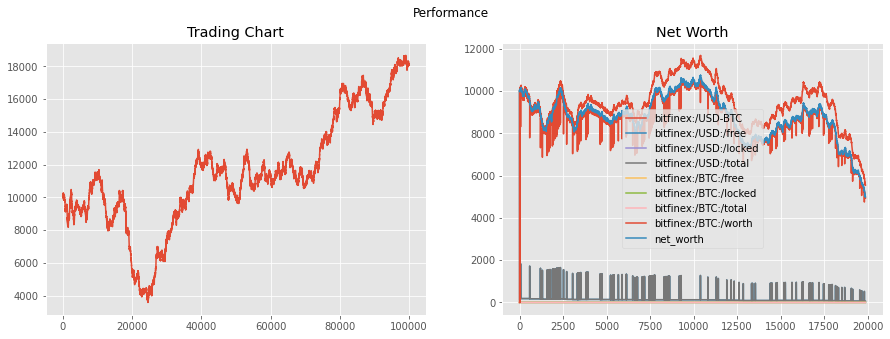

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Performance")

axs[0].plot(np.arange(len(data["close"])), data["close"], label="price")
axs[0].set_title("Trading Chart")

performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
performance_df.plot(ax=axs[1])
axs[1].set_title("Net Worth")

plt.show()

#### Create new data to assess how the agent behaves in data you've never seen

<AxesSubplot:>

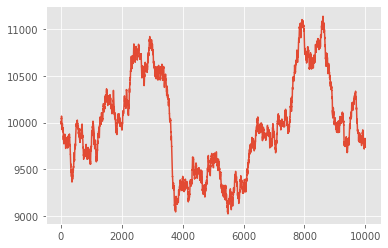

In [15]:
data2 = sp.fbm(
    base_price=10000,
    base_volume=5000,
    start_date="2010-01-01",
    times_to_generate=10000,
    time_frame='1H'
)
data2 = data2.reset_index(drop=True)
data2.close.plot()


In [16]:
data2 = fetchTaFeatures(data2)

/home/leandro/Documentos/ReinforcementLearningTrading/test/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/leandro/Documentos/ReinforcementLearningTrading/test/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [17]:
norm_data = pd.DataFrame(scaler.transform(data2), columns=data2.columns)

In [18]:
env = createEnv({
    "window_size": 10, 
    "data": norm_data
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.get_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

#### Ploting performance in test data

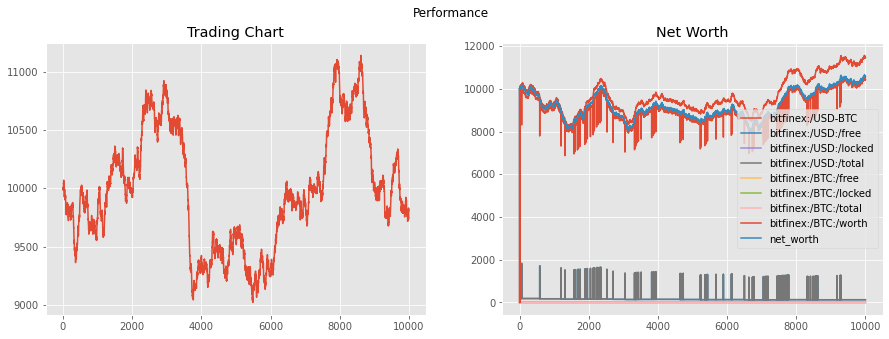

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Performance")

axs[0].plot(np.arange(len(data2["close"])), data2["close"], label="price")
axs[0].set_title("Trading Chart")

performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
performance_df.plot(ax=axs[1])
axs[1].set_title("Net Worth")
# axs[1].set_xlim(0, 800)

plt.show()